In [19]:
import os
import numpy as np
import pandas as pd
import uproot as ur

import sys
sys.path.append('../..')
from jupyter_utils import *

from matplotlib import pyplot as plt
from IPython.display import Image
pd.set_option('display.max_columns', None) # to see all columns of df.head()
pd.set_option('display.max_rows', None)

# Lauren's colors
L_colors = ['red', 'darkorange', 'limegreen', 'green', 'deepskyblue', 'blue', 'black']
L_linestyles = ['solid', 'dashed', 'dotted']

In [20]:
# file defs

base_dir = "/global/cfs/cdirs/alice/kdevero/"
fs = [base_dir+"PbPb_jet-trk/22850206/merged.root"]
#fs = ["./output_data/temp/merged.root"]
f_names = ["PbPb"]

f = ur.open(fs[0])


(-0.2, 6.5)

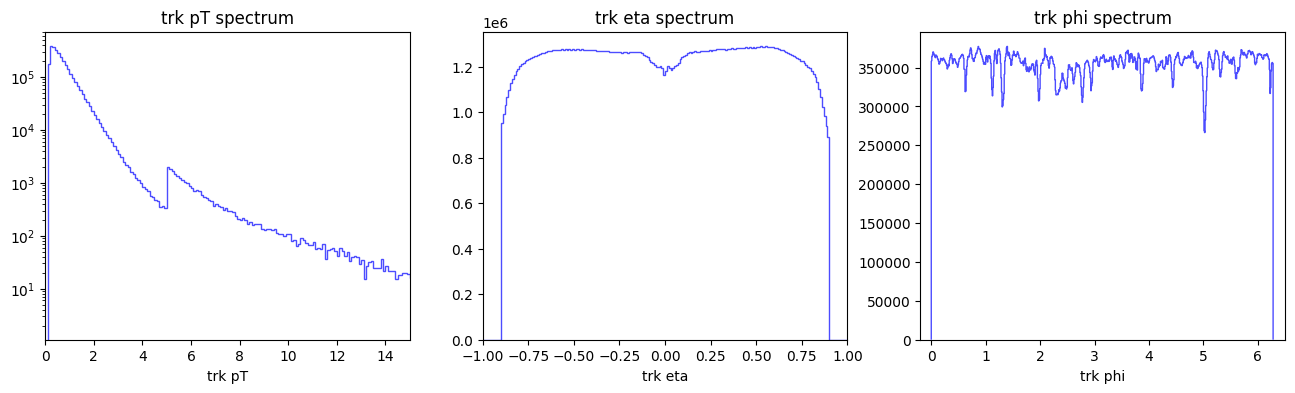

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))

ax = axes[0]

h = f["h_trk_pt_TrkPt_R0.4_0.15"]
bin_edges = h.axis("x").edges()
bin_width = bin_edges[1] - bin_edges[0]
this_slice = h.values()
ax.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color="blue")

ax.set_title("trk pT spectrum") 
ax.set_xlabel('trk pT')
ax.set_xlim([0, 15])
ax.set_yscale('log')

ax = axes[1]

h = f["hTrackEtaPhi"]
eta = projectionX(h.values())
phi = projectionY(h.values())

eta_edges = h.axis("x").edges()
ax.hist(eta_edges[:-1], eta_edges, weights=eta, lw=1, histtype = 'step', alpha=0.7, fill=False, color="blue")

ax.set_title("trk eta spectrum") 
ax.set_xlabel('trk eta')
ax.set_xlim([-1, 1])

ax = axes[2]

phi_edges = h.axis("y").edges()
ax.hist(phi_edges[:-1], phi_edges, weights=phi, lw=1, histtype = 'step', alpha=0.7, fill=False, color="blue")

ax.set_title("trk phi spectrum") 
ax.set_xlabel('trk phi')
ax.set_xlim([-0.2, 6.5])


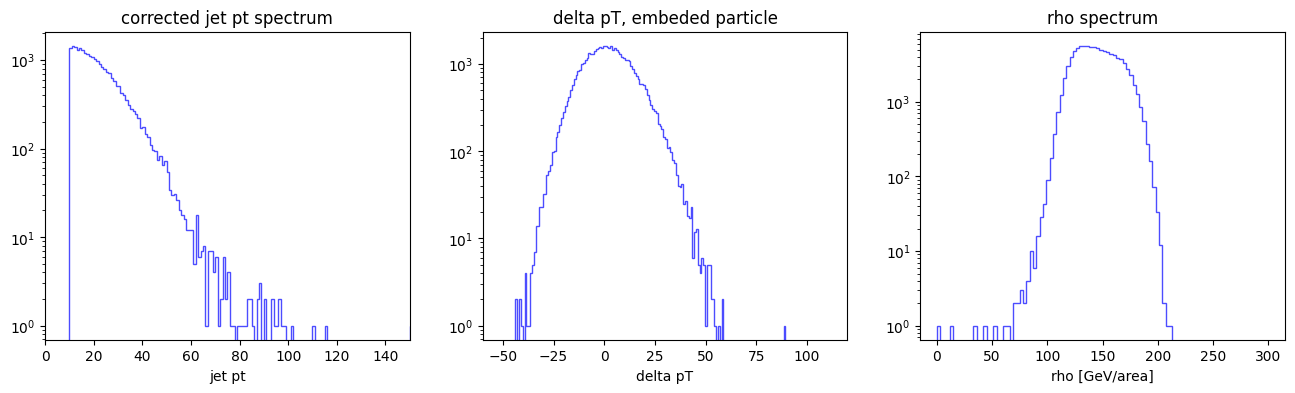

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))

ax = axes[0]

h = f["h_jet_pt_JetPt_R0.4_0.15"]
bin_edges = h.axis("x").edges()
bin_width = bin_edges[1] - bin_edges[0]
this_slice = h.values()
ax.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color="blue")

ax.set_title("corrected jet pt spectrum") 
ax.set_xlabel('jet pt')
ax.set_xlim([0, 150])
ax.set_yscale('log')

ax = axes[1]

h = f["hDelta_pt"]
bin_edges = h.axis("x").edges()
bin_width = bin_edges[1] - bin_edges[0]
this_slice = h.values()
ax.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color="blue")

ax.set_title("delta pT, embeded particle") 
ax.set_xlabel('delta pT')
ax.set_xlim([-60, 120])
ax.set_yscale('log')

ax = axes[2]

h = f["hRho"]
bin_edges = h.axis("x").edges()
bin_width = bin_edges[1] - bin_edges[0]
this_slice = h.values()
ax.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color="blue")

ax.set_title("rho spectrum") 
ax.set_xlabel('rho [GeV/area]')
ax.set_yscale('log')
    

In [23]:
# load in all hists
shape_pt = f["h_jet-trk_shape_RL_TrkPt_JetPt_R0.4_0.15"]
shape_z = f["h_jet-trk_shape_RL_z_JetPt_R0.4_0.15"]
ptprofile_pt = f["h_jet-trk_ptprofile_RL_TrkPt_JetPt_R0.4_0.15"]
ptprofile_z = f["h_jet-trk_ptprofile_RL_z_JetPt_R0.4_0.15"]

trkpt_perp = f["h_perpcone_trk_pt_TrkPt_R0.4_0.15"]
shape_pt_perp = f["h_perpcone_jet-trk_shape_RL_TrkPt_JetPt_R0.4_0.15"]

# define trk and jet pt bins
N_trkpt_bins = 4
trk_pt_lo = [1, 2, 4, 7]
trk_pt_hi = [2, 4, 7, 20]

jet_pt_lo = 30
jet_pt_hi = 80

# define all other binnings, assumes all hists have same bin defs as shape_pt
R_bins = shape_pt.axis("x").edges()
trkpt_bins = shape_pt.axis("y").edges()
jetpt_bins = shape_pt.axis("z").edges()

def findbin(edges, value):
    for i in range(len(edges)-1):
        if edges[i] <= value and value < edges[i+1]:
            return i
    return len(edges)-1

# cut on jet pT
def cut_on_jetpt(h):
    pt_range = (findbin(jetpt_bins, jet_pt_lo), findbin(jetpt_bins, jet_pt_hi))
    return zslice(h.values(), pt_range[0], pt_range[1])

shape_pt = cut_on_jetpt(shape_pt)
shape_pt_perp = cut_on_jetpt(shape_pt_perp)

# rebin in terms of defined track pt bins
def rebin_trkpt(h):
    new_h = []
    for i in range(N_trkpt_bins):
        trk_pt_range = (findbin(trkpt_bins, trk_pt_lo[i]), findbin(trkpt_bins, trk_pt_hi[i]))
        new_h.append(yslice(h, trk_pt_range[0], trk_pt_range[1]))
    return np.array(new_h).T

shape_pt = rebin_trkpt(shape_pt)
shape_pt_perp = rebin_trkpt(shape_pt_perp)

# rebin so RL bins larger...
def rebin_RL(h):
    new_h = []
    for row in h.T:
        this_new_h, new_bins = rebin(row, R_bins, 5)
        new_h.append(this_new_h)
    return np.array(new_h), new_bins
        
shape_pt, R_bins = rebin_RL(shape_pt)
shape_pt_perp, _ = rebin_RL(shape_pt_perp)

print(shape_pt)
print(R_bins)

print(shape_pt.shape)
print(R_bins.shape)




[[3.0040e+02 9.2320e+02 1.4966e+03 2.0350e+03 2.5562e+03 3.0302e+03
  3.3694e+03 3.7156e+03 3.9484e+03 3.2230e+03]
 [1.0100e+02 2.7320e+02 4.4720e+02 5.9100e+02 6.7140e+02 7.4940e+02
  7.9100e+02 8.1540e+02 7.9820e+02 4.9640e+02]
 [4.8200e+01 1.1380e+02 1.6360e+02 1.5860e+02 1.4540e+02 1.3320e+02
  9.9800e+01 6.9400e+01 5.2800e+01 1.0800e+01]
 [4.6600e+01 1.1160e+02 1.1860e+02 9.6600e+01 6.3400e+01 3.8000e+01
  2.1200e+01 1.2200e+01 3.4000e+00 2.0000e-01]]
[0.         0.04       0.08       0.12       0.16       0.2
 0.23999999 0.28       0.31999999 0.36000001 0.40000001]
(4, 10)
(11,)


In [24]:
# find number of jets in selected jet pt bin

h = f["h_jet_pt_JetPt_R0.4_0.15"]
h_jetpt = h.values()
pt_range = (findbin(jetpt_bins, jet_pt_lo), findbin(jetpt_bins, jet_pt_hi))
h_jetpt = h_jetpt[pt_range[0]:pt_range[1]]
N_jets = np.sum(h_jetpt)

print("Njets : " + str(N_jets))


Njets : 4582.0


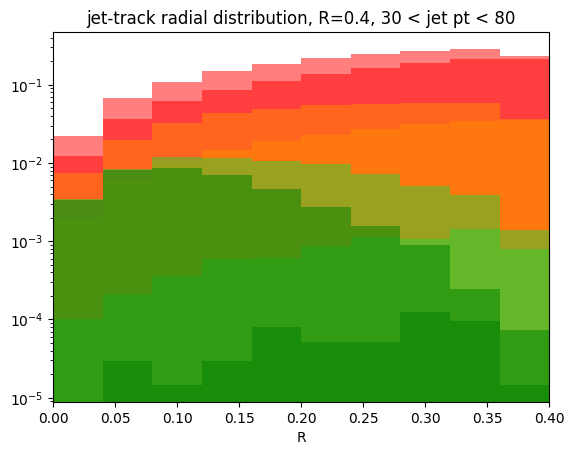

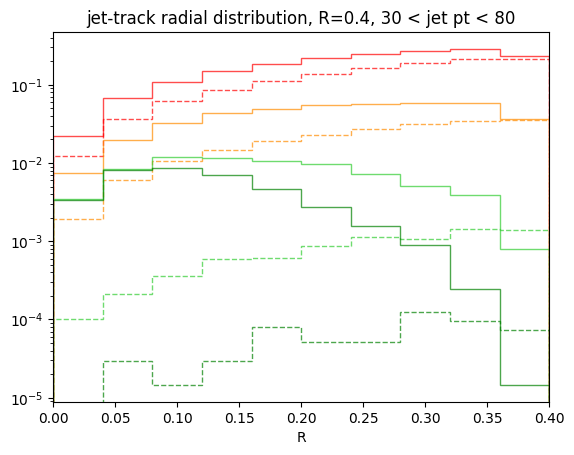

In [33]:
for i in range(N_trkpt_bins):
    this_slice = shape_pt[i] / (N_jets * bin_width)

    plt.hist(R_bins[:-1], R_bins, weights=this_slice, alpha=0.5, color=L_colors[i], label='{} < trk pT < {}'.format(trk_pt_lo[i], trk_pt_hi[i]))

    this_slice_perp = shape_pt_perp[i] / (N_jets * bin_width * 2) # two cones per signal cone

    plt.hist(R_bins[:-1], R_bins, weights=this_slice_perp, alpha=0.5, color=L_colors[i], label='{} < trk pT < {}'.format(trk_pt_lo[i], trk_pt_hi[i]))

#plt.legend(loc='upper left')
plt.title("jet-track radial distribution, R=0.4, {} < jet pt < {}".format(jet_pt_lo, jet_pt_hi)) 
plt.xlabel('R') 
plt.xlim(0, 0.4)
#plt.ylim(0, 0.5)
plt.yscale("log")

plt.show()

for i in range(N_trkpt_bins):
    this_slice = shape_pt[i] / (N_jets * bin_width)

    plt.hist(R_bins[:-1], R_bins, weights=this_slice, histtype="step", alpha=0.7, color=L_colors[i], label='{} < trk pT < {}'.format(trk_pt_lo[i], trk_pt_hi[i]))

    this_slice_perp = shape_pt_perp[i] / (N_jets * bin_width * 2) # two cones per signal cone

    plt.hist(R_bins[:-1], R_bins, weights=this_slice_perp, histtype="step", alpha=0.7, linestyle=L_linestyles[1], color=L_colors[i], label='{} < trk pT < {}'.format(trk_pt_lo[i], trk_pt_hi[i]))

#plt.legend(loc='upper left')
plt.title("jet-track radial distribution, R=0.4, {} < jet pt < {}".format(jet_pt_lo, jet_pt_hi)) 
plt.xlabel('R') 
plt.xlim(0, 0.4)
#plt.ylim(0, 0.5)
plt.yscale("log")

plt.show()

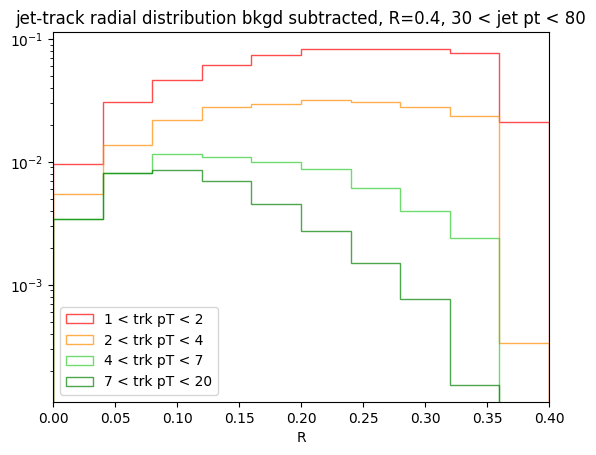

In [34]:
for i in range(len(trk_pt_lo)):
    this_slice = shape_pt[i] / (N_jets * bin_width)

    this_slice_perp = shape_pt_perp[i] / (N_jets * bin_width * 2) # two cones per signal cone

    this_slice_sub = this_slice - this_slice_perp
    plt.hist(R_bins[:-1], R_bins, weights=this_slice_sub, lw=1, histtype = 'step', alpha=0.7, fill=False, linestyle=L_linestyles[0], color=L_colors[i], label='{} < trk pT < {}'.format(trk_pt_lo[i], trk_pt_hi[i]))

    plt.legend(loc="lower left")
    plt.title("jet-track radial distribution bkgd subtracted, R=0.4, {} < jet pt < {}".format(jet_pt_lo, jet_pt_hi)) 
    plt.xlabel('R')
    plt.xlim(0, 0.4)
    plt.yscale("log")

plt.show()

In [27]:
hs = []
for i in range(len(fs)):
    f = ur.open(fs[i])
    h = f[n_ptprofile_pt]
    
    h_numpy = h.to_numpy()[0]
    pt_range = (findbin(h.axis("z"), jet_pt_lo[jet_pt_sel]), findbin(h.axis("z"), jet_pt_hi[jet_pt_sel]))
    h_numpy = projectionX(zslice(h_numpy, pt_range[0], pt_range[1]))

    n_r_bins = 50
    bin_edges = np.linspace(0, 0.4, n_r_bins)
    bin_widths = 0.4 / n_r_bins
    
    h_to_graph = np.array([np.sum(h_numpy[0:findbin(h.axis("x"), bin_edges[i])]) for i in range(n_r_bins-1)])
    print(h_to_graph)
    
    # normalization by inclusive RL selection
    h_to_graph = h_to_graph / h_to_graph[len(h_to_graph)-1]
    hs.append(h_to_graph)
    
    plt.hist(bin_edges[:-1], bin_edges, weights=h_to_graph, lw=1, histtype = 'step', alpha=0.7, fill=False, color=L_colors[3*i], label=f_names[i])
    
plt.axhline(1, linestyle='--', color='gray')
plt.legend(loc='lower right')
plt.title("track pT density profile, R=0.4") 
plt.xlabel('R')
plt.xlim(0, 0.4)
plt.ylim(0, 1.1)
plt.show()


NameError: name 'n_ptprofile_pt' is not defined

(10, 20)
(10, 40)
(10, 70)
(10, 200)


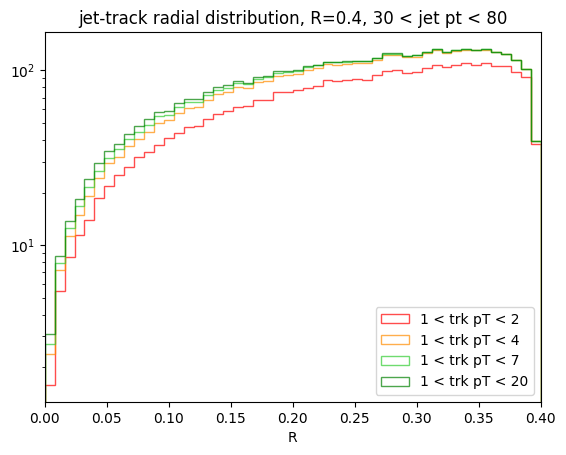

In [ ]:
f = ur.open(fs[0])
h = f[n_shape_pt]
bin_edges = h.axis("x").edges()
bin_width = bin_edges[1] - bin_edges[0]

h_numpy = h.to_numpy()[0]
pt_range = (findbin(h.axis("z"), jet_pt_lo[jet_pt_sel]), findbin(h.axis("z"), jet_pt_hi[jet_pt_sel]))
h_numpy = zslice(h_numpy, pt_range[0], pt_range[1])

for i in range(len(trk_pt_lo)):
    trk_pt_range = (findbin(h.axis("y"), trk_pt_lo[0]), findbin(h.axis("y"), trk_pt_hi[i]))
    print(trk_pt_range)
    
    this_slice = yslice(h_numpy, trk_pt_range[0], trk_pt_range[1])
    this_slice = this_slice / (N_jets[fi] * bin_width)
    
    plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color=L_colors[i], label='{} < trk pT < {}'.format(trk_pt_lo[0], trk_pt_hi[i]))
    
plt.legend(loc='lower right')
plt.title("jet-track radial distribution, R=0.4, {} < jet pt < {}".format(jet_pt_lo[jet_pt_sel], jet_pt_hi[jet_pt_sel])) 
plt.xlabel('R')
plt.yscale("log")
plt.xlim(0, 0.4)
#plt.ylim(5e2, 2e5)
plt.show()

(10, 20)
(10, 40)
(10, 70)
(10, 200)


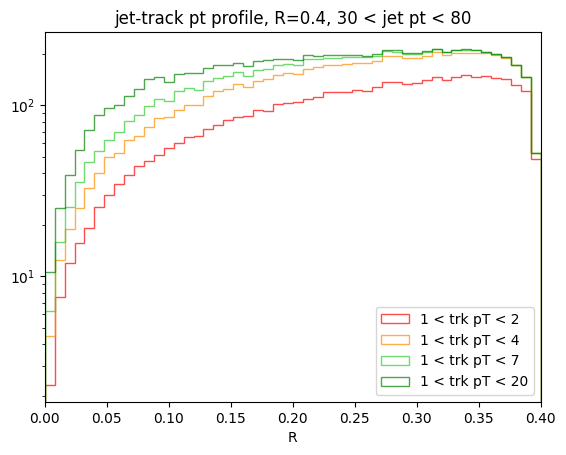

In [ ]:
f = ur.open(fs[0])
h = f[n_ptprofile_pt]
bin_edges = h.axis("x").edges()
bin_width = bin_edges[1] - bin_edges[0]

h_numpy = h.to_numpy()[0]
pt_range = (findbin(h.axis("z"), jet_pt_lo[jet_pt_sel]), findbin(h.axis("z"), jet_pt_hi[jet_pt_sel]))
h_numpy = zslice(h_numpy, pt_range[0], pt_range[1])

for i in range(len(trk_pt_lo)):
    trk_pt_range = (findbin(h.axis("y"), trk_pt_lo[0]), findbin(h.axis("y"), trk_pt_hi[i]))
    print(trk_pt_range)
    
    this_slice = yslice(h_numpy, trk_pt_range[0], trk_pt_range[1])
    this_slice = this_slice / (N_jets[fi] * bin_width)
    
    plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color=L_colors[i], label='{} < trk pT < {}'.format(trk_pt_lo[0], trk_pt_hi[i]))
    
plt.legend(loc='lower right')
plt.title("jet-track pt profile, R=0.4, {} < jet pt < {}".format(jet_pt_lo[jet_pt_sel], jet_pt_hi[jet_pt_sel])) 
plt.xlabel('R')
plt.yscale("log")
plt.xlim(0, 0.4)
#plt.ylim(5e2, 2e5)
plt.show()
